In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel


In [2]:
# load the dataset
df = pd.read_csv('data/churn_dataset.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# Rename columns with '_' instead of spaces
df.columns = df.columns.str.replace(' ','_')

# Drop the phone number column.
# df.drop('phone_number', axis=1, inplace=True)
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

In [4]:
#Perfoming label encoding
#False becomes 0 and True becomes 1
encoder = LabelEncoder()
df['churn'] = encoder.fit_transform(df['churn'])


In [5]:
df.drop('phone_number', axis=1, inplace=True)

In [6]:
df.drop('state', axis=1, inplace=True)
df.drop('area_code', axis=1, inplace=True)

In [7]:
#Performing label encoding
#No becomes 0 and yes becomes 1.
df['international_plan'] = encoder.fit_transform(df['international_plan'])
df['voice_mail_plan'] = encoder.fit_transform(df['voice_mail_plan'])


In [8]:
df.drop(labels=['number_vmail_messages', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'],
       axis=1,
       inplace=True)
df.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,0,1,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [9]:
# Define X and y, and split train/test data
df_copy = df.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y)

In [10]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

0    2137
1     362
Name: churn, dtype: int64
------------------------------
Synthetic sample class distribution: 

1    2137
0    2137
Name: churn, dtype: int64


In [11]:
logreg_model_l1_resampling = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_model_l1_resampling.fit(X_train_resampled,y_train_resampled)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

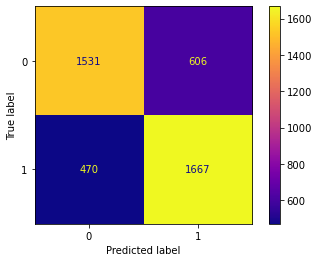

In [12]:
ConfusionMatrixDisplay.from_estimator(logreg_model_l1_resampling,X_train_resampled,y_train_resampled,cmap='plasma');

In [13]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring = 'recall')
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} recall
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [14]:
selector = SelectFromModel(logreg_model_l1_resampling)

selector.fit(X_train_resampled, y_train_resampled)

SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))

In [15]:
sup = selector.get_support()
unique, counts = np.unique(sup, return_counts=True)
print(np.asarray((unique, counts)).T)
#We are only keeping 58 columns


[[ 1 12]]


In [16]:
dict(zip(X_train_resampled.columns, selector.get_support()))

{'account_length': True,
 'international_plan': True,
 'voice_mail_plan': True,
 'total_day_minutes': True,
 'total_day_calls': True,
 'total_eve_minutes': True,
 'total_eve_calls': True,
 'total_night_minutes': True,
 'total_night_calls': True,
 'total_intl_minutes': True,
 'total_intl_calls': True,
 'customer_service_calls': True}

In [17]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [18]:
X_train_selected = select_important_features(X=X_train_resampled, selector=selector)

In [19]:
logreg_sel_model = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_sel_model.fit(X_train_selected,y_train_resampled)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

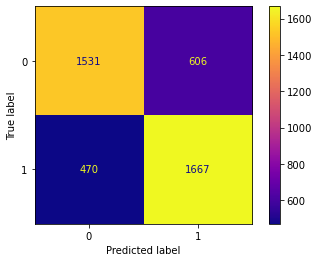

In [20]:
ConfusionMatrixDisplay.from_estimator(logreg_sel_model,X_train_selected,y_train_resampled,cmap='plasma');

In [21]:
logreg1_SMOTE_results = ModelWithCV(
                                        logreg_model_l1_resampling,
                                        'L1_resampling',
                                        X_train_resampled,
                                        y_train_resampled
)

logreg1_SMOTE_featureselect_results = ModelWithCV(
                                        logreg_sel_model,
                                        'L1_resampling_feature_select',
                                        X_train_selected,
                                        y_train_resampled
)


model_results = [
    logreg1_SMOTE_results,
    logreg1_SMOTE_featureselect_results
]


CV Results for `L1_resampling` model:
            0.77120 ± 0.02555 recall
        
CV Results for `L1_resampling_feature_select` model:
            0.77120 ± 0.02555 recall
        


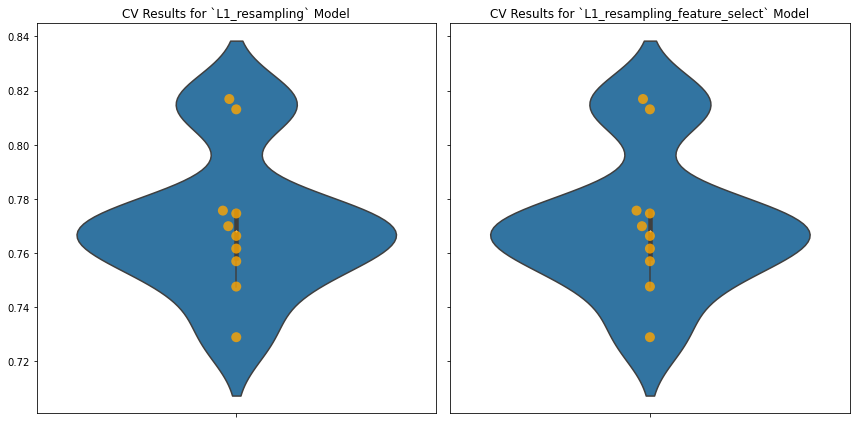

In [22]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();
#Now with cross validation, higher tolerance is better.

In [23]:
model_results = [logreg1_SMOTE_featureselect_results]
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
#We are trying to figure out c. with hyperparamter tunning and cross valiudation
for c in C_values:
    logreg_model = LogisticRegression(random_state=42,solver='liblinear',penalty='l1', C=c) #solver = "liblinear"
    logreg_model.fit(X_train_selected, y_train_resampled)
    # Save Results
    new_model_results = ModelWithCV(
                            logreg_model,
                            f'scaled_features_c{c:e}',
                            X_train_selected,
                            y_train_resampled
    )
    model_results.append(new_model_results)
    new_model_results.print_cv_summary()

CV Results for `scaled_features_c1.000000e-04` model:
            0.91113 ± 0.04448 recall
        
CV Results for `scaled_features_c1.000000e-03` model:
            0.57231 ± 0.03326 recall
        
CV Results for `scaled_features_c1.000000e-02` model:
            0.74875 ± 0.03215 recall
        
CV Results for `scaled_features_c1.000000e-01` model:
            0.77916 ± 0.03226 recall
        
CV Results for `scaled_features_c1.000000e+00` model:
            0.77120 ± 0.02555 recall
        


In [24]:
logreg_model_bsf = LogisticRegression(random_state=42,solver='liblinear',penalty='l1', C=0.0001)
logreg_model_bsf.fit(X_train_selected, y_train_resampled)

LogisticRegression(C=0.0001, penalty='l1', random_state=42, solver='liblinear')

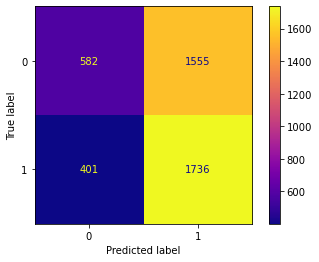

In [25]:
ConfusionMatrixDisplay.from_estimator(logreg_model_bsf,X_train_selected,y_train_resampled,cmap='plasma');

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [27]:
def scale(X, scaler):
    '''
    Takes DataFrame and fitted scaler as input.
    '''
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled,columns=X.columns,index=X.index)
    return X_scaled

In [28]:
X_train_scaled = scale(X_train_selected,scaler)
X_train_scaled.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls
0,0.047680,-0.321421,-0.620689,0.003946,1.682382,-2.026492,-0.752785,-0.374243,1.733515,-0.665172,-0.601211,-0.426869
1,-0.479760,-0.321421,-0.620689,0.107169,-3.252032,1.507305,1.721096,-0.167396,0.205022,-1.646632,1.018220,1.850881
2,-1.584873,-0.321421,-0.620689,-0.899251,-0.130260,-0.737882,-0.146937,-0.825725,0.306922,-0.737873,0.613362,0.332381
3,-2.237894,3.111187,-0.620689,0.676736,0.826412,-1.654930,1.317197,0.387509,0.510721,-0.156267,-0.196354,0.332381
4,0.047680,-0.321421,1.611112,-0.759163,-1.036581,-1.150949,0.408425,-0.332476,-1.170621,0.570740,1.018220,-0.426869


In [29]:
logreg_scaled = LogisticRegression(random_state=42)
logreg_scaled.fit(X_train_scaled,y_train_resampled)

LogisticRegression(random_state=42)

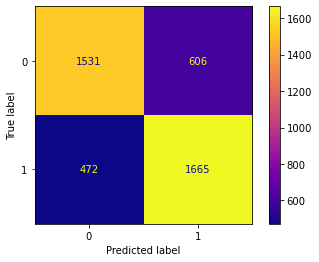

In [30]:
ConfusionMatrixDisplay.from_estimator(logreg_scaled,X_train_scaled,y_train_resampled,cmap='plasma');

In [31]:
logreg1_SMOTE_scaled_results = ModelWithCV(
                                        logreg_scaled,
                                        'L1_resampling/scaled',
                                        X_train_scaled,
                                        y_train_resampled
)


In [32]:
model_results = [logreg1_SMOTE_scaled_results]
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
#We are trying to figure out c. with hyperparamter tunning and cross valiudation
for c in C_values:
    logreg_model = LogisticRegression(random_state=42,solver='liblinear',penalty='l1', C=c) #solver = "liblinear"
    logreg_model.fit(X_train_scaled, y_train_resampled)
    # Save Results
    new_model_results = ModelWithCV(
                            logreg_model,
                            f'scaled_features_c{c:e}',
                            X_train_scaled,
                            y_train_resampled
    )
    model_results.append(new_model_results)
    new_model_results.print_cv_summary()

CV Results for `scaled_features_c1.000000e-04` model:
            0.00000 ± 0.00000 recall
        
CV Results for `scaled_features_c1.000000e-03` model:
            0.00000 ± 0.00000 recall
        
CV Results for `scaled_features_c1.000000e-02` model:
            0.81005 ± 0.03003 recall
        
CV Results for `scaled_features_c1.000000e-01` model:
            0.77307 ± 0.02567 recall
        
CV Results for `scaled_features_c1.000000e+00` model:
            0.77167 ± 0.02521 recall
        
